# Scaling of derivative errors

In this notebook we explore how the errors of derivative operators realized as matrices on a coordinate space mesh scale with the spacing of the mesh.

**Most of what you need is already here. Things to play with:**
- The choice of function (`f_test`).
- What point you evaluate the derivative at (`x_pt`).
- The range of $\Delta x$ to plot (`min_exp` and `max_exp`).


Standard imports plus seaborn (to make plots looks nicer).

In [1]:
import numpy as np
import scipy.linalg as la

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")


We'll define two functions that create matrices that implement approximate derivatives when applied to a vector made up of a function evaluated at the mesh points. The numpy `diag` and `ones` functions are used to create matrices with 1's on particular diagonals, as in these $5\times 5$ examples of forward derivatives: 

$$ \frac{1}{\Delta x}\,\left( 
    \begin{array}{ccccc}
    -1 & 1 & 0 & 0 & 0 \\
    0 & -1 & 1 & 0 & 0 \\
    0 & 0 & -1 & 1 & 0 \\
    0 & 0 &0 & -1 & 1 \\
    0 & 0 & 0 & 0 & -1
    \end{array}
   \right) 
   \left(\begin{array}{c}
         f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5
         \end{array}
   \right) 
   \overset{?}{=}
   \left(\begin{array}{c}
         ? \\ ? \\ ? \\ ? \\ ?
         \end{array}
   \right) 
 $$  
 
 and symmetric derivatives:

$$
   \frac{1}{2\Delta x}\,\left( 
    \begin{array}{ccccc}
    0 & 1 & 0 & 0 & 0 \\
    -1 & 0 & 1 & 0 & 0 \\
    0 & -1 & 0 & 1 & 0 \\
    0 & 0 & -1 & 0 & 1 \\
    0 & 0 & 0 & -1 & 0
    \end{array}
   \right) 
   \left(\begin{array}{c}
         f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5
         \end{array}
   \right)
   \overset{?}{=}
   \left(\begin{array}{c}
         ? \\ ? \\ ? \\ ? \\ ?
         \end{array}
   \right) 
$$
 

In [2]:
def forward_derivative_matrix(N, Delta_x):
    """Return an N x N matrix for derivative of an equally spaced vector by delta_x
    """
    return ( np.diag(np.ones(N-1), +1) - np.diag(np.ones(N), 0) ) / Delta_x

In [3]:
def symmetric_derivative_matrix(N, Delta_x):
    """Return an N x N matrix for derivative of an equally spaced vector by delta_x
    """
    return ( np.diag(np.ones(N-1), +1) - np.diag(np.ones(N-1), -1) ) / (2 * Delta_x)

In [4]:
def Richardson_derivative_matrix(N, Delta_x):
    """Return an N x N matrix for derivative of an equally spaced vector by delta_x
    """
    sym_matrix_delta_x = symmetric_derivative_matrix(N, Delta_x)
    sym_matrix_2_delta_x = ( np.diag(np.ones(N-2), +2) - np.diag(np.ones(N-2), -2) ) / (4 * Delta_x)
    return (4 * sym_matrix_delta_x - sym_matrix_2_delta_x) / 3

## Testing forward against symmetric derivative

We'll check the relative accuracy of both approximate derivatives as a function of $\Delta x$ by choosing a test function $f(x)$ and a range of $x$.

In [5]:
def make_x_mesh(Delta_x, x_pt, N_pts):
    """
    Return a grid of N_pts points centered at x_pt and spaced by Delta_x
    """
    x_min = x_pt - Delta_x * (N_pts - 1)/2
    x_max = x_pt + Delta_x * (N_pts - 1)/2
    return np.linspace(x_min, x_max, N_pts)

In [6]:
# testing!
Delta_x = 0.02
x_pt = 1.
N_pts = 5

x_mesh = make_x_mesh(Delta_x, x_pt, N_pts)

In [7]:
# Check that mesh is consistent with Delta_x
print(Delta_x)
print(x_mesh)

0.02
[0.96 0.98 1.   1.02 1.04]


Set up the derivative matrices for the specified mesh.

In [8]:
fd = forward_derivative_matrix(N_pts, Delta_x)
sd = symmetric_derivative_matrix(N_pts, Delta_x)
rd = Richardson_derivative_matrix(N_pts, Delta_x)

In [9]:
print(fd)

[[-50.  50.   0.   0.   0.]
 [  0. -50.  50.   0.   0.]
 [  0.   0. -50.  50.   0.]
 [  0.   0.   0. -50.  50.]
 [  0.   0.   0.   0. -50.]]


In [10]:
print(sd)

[[  0.  25.   0.   0.   0.]
 [-25.   0.  25.   0.   0.]
 [  0. -25.   0.  25.   0.]
 [  0.   0. -25.   0.  25.]
 [  0.   0.   0. -25.   0.]]


In [11]:
print(rd)

[[  0.          33.33333333  -4.16666667   0.           0.        ]
 [-33.33333333   0.          33.33333333  -4.16666667   0.        ]
 [  4.16666667 -33.33333333   0.          33.33333333  -4.16666667]
 [  0.           4.16666667 -33.33333333   0.          33.33333333]
 [  0.           0.           4.16666667 -33.33333333   0.        ]]


### Set up various test functions

In [12]:
def f_test_1(x_mesh):
    """
    Return the value of the function x^4 e^{-x} and its derivative
    """
    return ( np.exp(-x_mesh) * x_mesh**4, (4 * x_mesh**3 - x_mesh**4) * np.exp(-x_mesh) )    

def f_test_2(x_mesh):
    """
    Return the value of the function 1/(1 + x) and its derivative
    """
    return ( 1/(1+x_mesh), -1/(1+x_mesh)**2 )

def f_test_3(x_mesh):
    """
    Return the value of the function 1/(1 + x) and its derivative
    """
    return ( (np.sin(x_mesh))**2, 2 * np.cos(x_mesh) * np.sin(x_mesh) )

Pick one of the test functions and evaluate the function and its derivative on the mesh.
Then apply the forward difference (fd) and symmetric difference (sd) matrices to the `f_test` vector (using the `@` symbol for matrix-vector, matrix-matrix, and vector-vector multiplication).

In [13]:
f_test, f_deriv_exact = f_test_1(x_mesh)

f_deriv_fd = fd @ f_test
f_deriv_sd = sd @ f_test
f_deriv_rd = rd @ f_test

Make plots comparing the exact to approximate derivative and then the relative errors.

In [14]:
def rel_error(x1, x2):
    """
    Calculate the (absolute value of the) relative error between x1 and x2
    """
    return np.abs( (x1 - x2) / ((x1 + x2)/2) )

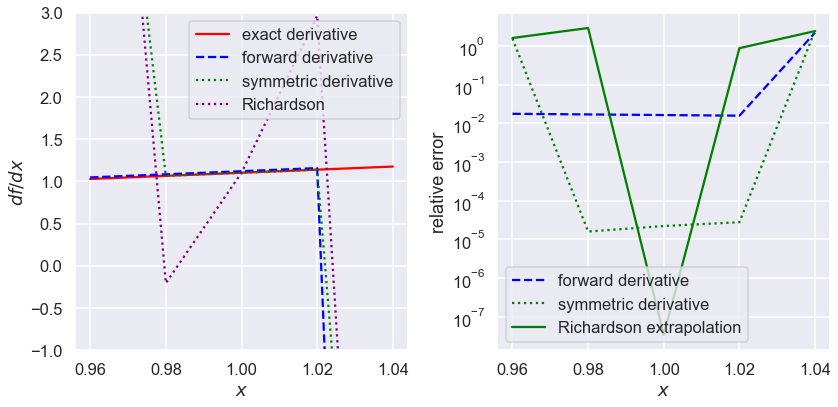

In [15]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$df/dx$')
#ax1.set_xlim(0, x_max)
ax1.set_ylim(-1., 3)

ax1.plot(x_mesh, f_deriv_exact, color='red', label='exact derivative')
ax1.plot(x_mesh, f_deriv_fd, color='blue', label='forward derivative', linestyle='dashed')
ax1.plot(x_mesh, f_deriv_sd, color='green', label='symmetric derivative', linestyle='dotted')
ax1.plot(x_mesh, f_deriv_rd, color='purple', label='Richardson', linestyle='dotted')

ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'relative error')
#ax2.set_xlim(0, x_max)
#ax2.set_ylim(-0.001, 0.001)

# Calculate relative errors
rel_error_fd = rel_error(f_deriv_exact, f_deriv_fd)
rel_error_sd = rel_error(f_deriv_exact, f_deriv_sd) 
rel_error_rd = rel_error(f_deriv_exact, f_deriv_rd) 

ax2.semilogy(x_mesh, rel_error_fd, color='blue', label='forward derivative', linestyle='dashed')
ax2.semilogy(x_mesh, rel_error_sd, color='green', label='symmetric derivative', linestyle='dotted')
ax2.semilogy(x_mesh, rel_error_rd, color='green', label='Richardson extrapolation', linestyle='solid')

ax2.legend()

fig.tight_layout()

## Test the scaling with Delta_x

In [16]:
x_pt = 1.
N_pts = 5
mid_pt_index = int((N_pts - 1)/2)
print(mid_pt_index)

2


In [21]:
# Set up the Delta_x array
min_exp = -12
max_exp = 0
num_Delta_x = 100
array_exp = np.linspace(min_exp, max_exp, num_Delta_x)

# initialize arrays to zero
Delta_x_array = np.zeros(len(array_exp))
rel_error_fd_array = np.zeros(len(array_exp))
rel_error_sd_array = np.zeros(len(array_exp))
rel_error_rd_array = np.zeros(len(array_exp))

print('  Delta_x     fd error     sd error     rd error')
for index, exp in enumerate(array_exp):  # step through the exponents in the array
    Delta_x = 10**exp  # calculate a new Delta_x

    x_mesh = make_x_mesh(Delta_x, x_pt, N_pts)
    
    fd = forward_derivative_matrix(N_pts, Delta_x)
    sd = symmetric_derivative_matrix(N_pts, Delta_x)
    rd = Richardson_derivative_matrix(N_pts, Delta_x)
    
    f_test, f_deriv_exact = f_test_1(x_mesh)

    f_deriv_fd = fd @ f_test
    f_deriv_sd = sd @ f_test
    f_deriv_rd = rd @ f_test
    
    # Calculate relative errors
    rel_error_fd = rel_error(f_deriv_exact, f_deriv_fd)[mid_pt_index]
    rel_error_sd = rel_error(f_deriv_exact, f_deriv_sd)[mid_pt_index]
    rel_error_rd = rel_error(f_deriv_exact, f_deriv_rd)[mid_pt_index]
     
    print(f'{Delta_x:.5e}  {rel_error_fd:.5e}  {rel_error_sd:.5e}  {rel_error_rd:.5e}')
    
    # add to arrays
    Delta_x_array[index] = Delta_x
    rel_error_fd_array[index] = rel_error_fd
    rel_error_sd_array[index] = rel_error_sd
    rel_error_rd_array[index] = rel_error_rd
    


  Delta_x     fd error     sd error     rd error
1.00000e-12  1.10032e-04  2.70822e-05  4.09076e-05
1.32194e-12  1.10032e-04  5.47329e-05  6.51017e-05
1.74753e-12  2.82214e-05  5.69210e-07  6.34372e-06
2.31013e-12  5.69210e-07  1.32566e-05  2.18976e-05
3.05386e-12  5.47329e-05  1.32566e-05  8.07194e-06
4.03702e-12  1.43952e-05  5.69210e-07  4.61549e-06
5.33670e-12  2.70822e-05  6.34372e-06  7.20783e-06
7.05480e-12  7.48219e-06  4.02569e-06  4.88981e-06
9.32603e-12  1.43952e-05  4.02569e-06  4.88981e-06
1.23285e-11  1.09387e-05  5.75394e-06  5.75394e-06
1.62975e-11  6.34372e-06  2.88726e-06  2.88726e-06
2.15443e-11  5.69210e-07  5.69210e-07  7.88790e-08
2.84804e-11  2.29745e-06  1.15903e-06  1.80711e-06
3.76494e-11  2.29745e-06  5.69210e-07  2.45165e-07
4.97702e-11  2.29745e-06  5.69210e-07  8.93255e-07
6.57933e-11  1.15903e-06  1.37151e-07  2.99173e-07
8.69749e-11  5.69210e-07  7.88790e-08  2.40901e-07
1.14976e-10  1.43333e-06  5.69210e-07  5.96214e-07
1.51991e-10  1.37151e-07  7.88790

### Make a log-log plot

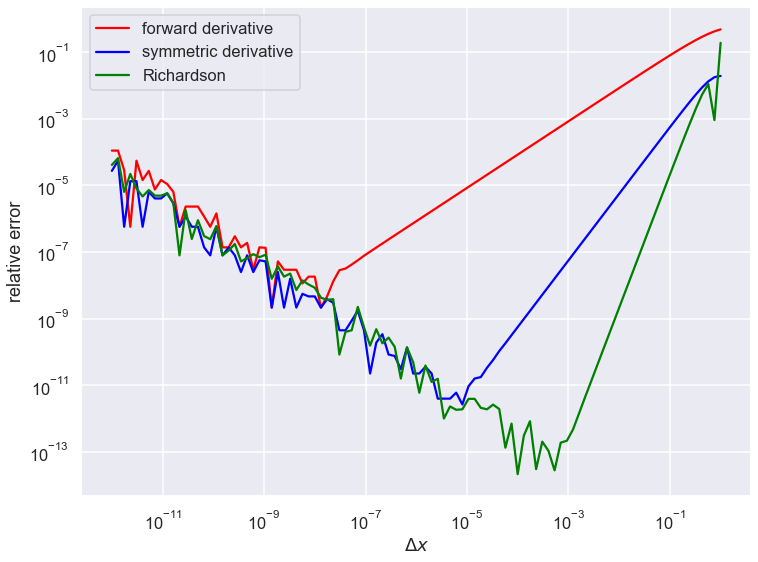

In [25]:
fig_new = plt.figure(figsize=(12,9))

ax1 = fig_new.add_subplot(1,1,1)
ax1.set_xlabel(r'$\Delta x$')
ax1.set_ylabel(r'relative error')
#ax1.set_xlim(0, x_max)
#ax1.set_ylim(-1., 3)

ax1.loglog(Delta_x_array, rel_error_fd_array, color='red', label='forward derivative')
ax1.loglog(Delta_x_array, rel_error_sd_array, color='blue', label='symmetric derivative')
ax1.loglog(Delta_x_array, rel_error_rd_array, color='green', label='Richardson')

ax1.legend();